# Better QR codes

QR codes are quite interesting, but boring to look at. For this reason I introduce SR codes, which stands for Snake Race codes. It improves QR codes on several fronts:

* Animation!
* Color!
* Hardcore. QR codes have error correction. SR codes don't. If you make an error it's game over.
* Not quick. Savour the wait before you can scan the code.

Developing a scanner app is left as an exercise for the reader :)

Seriously: QR codes are seriously interesting. Error correction and packing as much information as you can in a small amount of pixels while keeping it robust is a nice challenge.

<table>
    <tr>
        <td> <img src="qrcode.png"/> </td>
        <td> &lt; </td>
        <td> <img src="animation.gif"/> </td>  
    </tr>
</table>

## Snake Race code implementation

Mandantory importing

In [1]:
import numpy as np
from typing import NamedTuple, Tuple
from numpy.random import default_rng
from matplotlib import cm
from PIL import Image, ImageDraw
import numpy as np
from typing import NamedTuple, Tuple
from numpy.random import default_rng
from matplotlib import cm
from PIL import Image, ImageDraw

Define the turns that the snake can take in terms of a rotation matrix

In [2]:
actions = [
    # Left
    np.array([
        [0, 1],
        [-1, 0]
    ]),
    # Straight
    np.array([
        [1, 0],
        [0, 1]
    ]),  
    # Right
    np.array([
        [0, -1],
        [1, 0]
    ])
]

Define a method to generat the _trails_ of the snakes

In [3]:
def generate_trails(size: int, bits):
    # Define quarter distance
    q = size // 4
    
    # Define the start positions of all snakes
    snakes = [
        {
            'c': 'Greens', 
            'position': np.array([q+1, q+1]), 
            'orientation':  np.array([1, 0]), 
            'trail': np.full((2*(size+2), 2*(size+2)), 0),
            'active': True
        },
        {
            'c': 'Reds', 
            'position': np.array([3*q+1, 1+1]), 
            'orientation': np.array([0, 1]), 
            'trail': np.full((2*(size+2), 2*(size+2)), 0),
            'active': True
        },
        {
            'c': 'Blues', 
            'position': np.array([3*q+1, 3*q+1]), 
            'orientation': np.array([-1, 0]), 
            'trail': np.full((2*(size+2), 2*(size+2)), 0),
            'active': True
        },
        {
            'c': 'Purples', 
            'position': np.array([q+1, 3*q+1]), 
            'orientation': np.array([0, -1]), 
            'trail': np.full((2*(size+2), 2*(size+2)), 0),
            'active': True
        }
    ]
    

    # Keep track of where the snakes have passed
    matrix = np.full((size+2, size+2), False)
    matrix[0, :] = True
    matrix[:, 0] = True
    matrix[-1, :] = True
    matrix[:, -1] = True
    
    # Go over the bits
    current_bit = 0
    iteration = 0
    
    # While there are active snakes try it out
    while any([snake['active'] for snake in snakes]):

        # For each active snake
        active_snakes = [snake for snake in snakes if snake['active']]
        for i, snake in enumerate(active_snakes) :
           
            # Get the bit or exit
            if current_bit >= len(bits):
                return snakes
            
            bit = bits[current_bit]
            
            # Get the possible actions
            possible_actions = [ action for action in actions 
                                if not matrix[ tuple(snake['position'] + action @ snake['orientation']) ] ]

            if len(possible_actions) == 0:
                snake['active'] = False
                continue  # See if other snakes can still play
            elif len(possible_actions) == 1:
                action = possible_actions[0]
            elif len(possible_actions) == 2:
                action = possible_actions[int(bit)]
            elif len(possible_actions) == 3:
                offset = iteration % 2
                action = possible_actions[(int(bit) + offset)]

            # Update
            current_bit += 1
            snake['orientation'] = action @ snake['orientation']
            prev_position = snake['position']
            snake['position'] = snake['position'] + snake['orientation']

            # Update boundaries where snakes have been
            matrix[ tuple(snake['position']) ] = True

            # Update the twice larger pretty image (so that there is space and it looks pretty)
            snake['trail'][ tuple(prev_position + snake['position']) ] = 2 * iteration
            snake['trail'][tuple(2 * snake['position']) ] = 2 * iteration + 1
        
        # Update iteration
        iteration += 1

    return snakes, current_bit, iteration

Some code that generates the image at a certain frame/point in time:

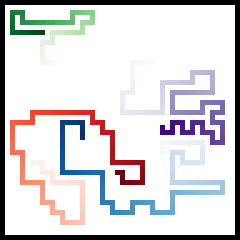

In [4]:
def generate_image(snakes, frame=np.inf, canvas_size = 44):

    
    # Define a transparant layer
    transparent = np.uint8(np.broadcast_to(np.array([255, 255, 255, 0]), (canvas_size, canvas_size, 4)))
    
    # Define the bottom layer
    composite = Image.new('RGBA', (canvas_size, canvas_size), (255,255,255,255))

    # Draw each trail
    for snake in snakes:
        trail = snake['trail'] * (snake['trail'] <= frame)
        color = cm.get_cmap(snake['c'])

        picture = np.full(trail.shape, 0)

        picture = np.uint8(color(trail / trail.max()) *255) * (trail > 0.)[:,:, np.newaxis]
        df = np.where(trail[:, :, np.newaxis] > 0, np.uint8(color(trail / trail.max()) *255), transparent)
        im = Image.fromarray(df)

        composite = Image.alpha_composite(composite, im)

    d = ImageDraw.Draw(composite)
    d.rectangle([(0, 0), (canvas_size-1, canvas_size-1)], fill=None, outline=(0,0,0,255), width=1)
    
    return composite.resize((5 * canvas_size, 5 * canvas_size), Image.NEAREST)


# Some settings
seed = 0
nr_bits = 500
size = 22

# Sizes of the canvas
canvas_size=2*(2+size)
canvas_size_xl = canvas_size * 5

# Generate some random bits
rng = default_rng(seed)
bits = rng.random(nr_bits) < 0.5

# Get the trails
snakes, nr_generated, max_iteration = generate_trails(
    size,
    bits
)

# Display
image = generate_image(snakes, frame=max_iteration, canvas_size=canvas_size)
display(image)

Finally we create a GIF image

In [5]:
# Create a gif
gif = Image.new('RGBA', (canvas_size_xl, canvas_size_xl))

gif.save('animation.gif', 
         save_all=True, 
         append_images=[generate_image(snakes, frame=frame, canvas_size=canvas_size) for frame in range(2, max_iteration)],
         duration=100, 
         loop=0)